<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
import time
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

In [22]:
%%time

!git clone -l -s git://github.com/kavyajeetbora/EAST.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 100 (delta 7), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (100/100), 4.45 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/cloned-repo/cloned-repo
dataset.py  dsiplay_ground_truth.ipynb	EAST_text_detector.ipynb  model.py
detect.py   EAST_detection.ipynb	loss.py			  train.py
CPU times: user 95.7 ms, sys: 232 ms, total: 327 ms
Wall time: 5.55 s


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
from dataset import *

In [25]:
# AI4Bharat dataset
image_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Images'
label_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Annotations'


# icdar dataset
# image_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/data/ICDAR dataset/Images'
# label_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/data/ICDAR dataset/Labels'

training_dataset = custom_dataset(image_address, label_address)
print(len(training_dataset))

428


## Dataset Initial Check

In [26]:
img = Image.open(image_address+'/5.jpg')

with open(label_address+'/5.txt', 'r') as f:
			lines = f.readlines()
vertices, labels = extract_vertices(lines)

img, vertices = adjust_height(img, vertices) 
img, vertices = rotate_img(img, vertices)
img, vertices = crop_img(img, vertices, labels, 512)

for vertice in vertices:
  print(vertice)
  print('-'*20)
  
print(labels)

[ 68.64947534 409.55094178 380.1391316  421.95293184 360.83965371
 506.08921333  68.12134728 480.81794367]
--------------------
[404.24890449 401.16046022 758.66277239 395.35356314 760.58218942
 529.78916973 389.45533392 504.6458457 ]
--------------------
[1 1]


In [27]:
score_map, geo_map, ignored_map = get_score_geo(img, vertices, labels, 0.25, 512)

torch.sum(score_map)

tensor(809.)

## Loss for one batch

In [28]:
%%time
train_loader = DataLoader(training_dataset, shuffle = True, batch_size=8)

imgs, gt_score, gt_geo, ignored_maps = next(iter(train_loader))

print(imgs.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())

print(torch.sum(gt_score))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128]) torch.Size([8, 1, 128, 128])
tensor(13248.)
CPU times: user 4.97 s, sys: 5.33 s, total: 10.3 s
Wall time: 10.9 s


In [0]:
from model import EAST

model = EAST()

In [30]:
pred_score, pred_geo = model(imgs)

print(pred_score.size(), pred_geo.size())

torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128])


In [31]:
from loss import Loss

loss_fn = Loss()

loss_fn(gt_score, pred_score, gt_geo, pred_geo, ignored_maps)

classify loss is 0.81292152, angle loss is 0.66264206, iou loss is 2.55670834


tensor(9.9960, grad_fn=<AddBackward0>)

## Training Full Batch 

fine tuning pretrained model [east_vgg16.pth](https://drive.google.com/file/d/1AFABkJgr5VtxWnmBU3XcfLJvpZkC2TAg/view)

In [0]:
from model import EAST

model = EAST()
state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/model_epoch_92.pth')
model.load_state_dict(state_dict)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [0]:
def train(model, train_img_path, train_gt_path, batch_size, lr, epoch_iter, num_workers=4, interval=1):
    file_num = len(os.listdir(train_img_path))
    print(file_num)
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)
	
    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)
    loss_curve = []
    
    for epoch in range(epoch_iter):
      model.train()
      scheduler.step()
      epoch_loss = 0
      epoch_time = time.time()
      for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
                  epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))
        
      print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
      print(time.asctime(time.localtime(time.time())))
      print('='*50)
      
      
      if (epoch + 1) % interval == 0:
        state_dict = model.state_dict()
        torch.save(state_dict, 'model_epoch_{}.pth'.format(epoch+1))
      
      ## plotting the loss curve
      loss_curve.append(epoch_loss/int(file_num/batch_size))
    return loss_curve

In [40]:
loss_curve = train(model, image_address, label_address, batch_size=8, lr=1e-3, epoch_iter=100)

428


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


classify loss is 0.05862445, angle loss is 0.00053507, iou loss is 0.14656875
Epoch is [1/100], mini-batch is [1/53], time consumption is 0.99882913, batch_loss is 0.21054389
classify loss is 0.10266614, angle loss is 0.00128768, iou loss is 0.23506898
Epoch is [1/100], mini-batch is [2/53], time consumption is 0.90127993, batch_loss is 0.35061195
classify loss is 0.06802189, angle loss is 0.00109561, iou loss is 0.17655277
Epoch is [1/100], mini-batch is [3/53], time consumption is 0.84526300, batch_loss is 0.25553080
classify loss is 0.06737357, angle loss is 0.00903783, iou loss is 0.19860168
Epoch is [1/100], mini-batch is [4/53], time consumption is 0.84279680, batch_loss is 0.35635355
classify loss is 0.08806044, angle loss is 0.00111170, iou loss is 0.22240651
Epoch is [1/100], mini-batch is [5/53], time consumption is 0.98548150, batch_loss is 0.32158396
classify loss is 0.07126969, angle loss is 0.00230212, iou loss is 0.17177337
Epoch is [1/100], mini-batch is [6/53], time co

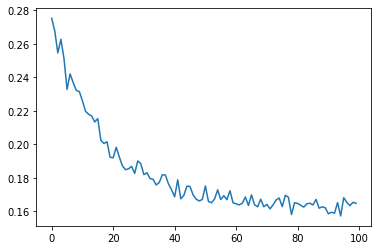

In [48]:
plt.plot(loss_curve)